Итоговое задание. Используем датасет 3 (сварные швы).

In [1]:
#импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pickle 
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(np.__version__)
print(pd.__version__)
print(sklearn.__version__)
print(tf.keras.__version__)
#print(pickle.__version__)
import flask
print(flask.__version__)

1.22.3
1.4.4
1.0.2
2.9.0
1.1.2


In [2]:
#функция для визуализации обучения нейросети
def plot_loss(history):
  plt.plot(history.history['loss'], label = 'loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error []')
  plt.legend()
  plt.grid(True)

In [3]:
#загрузка датасета ebw
name_dir = 'C:/Users/i.gliva/Documents/Обучение_Бауманка/Итоговая аттестация/Датасет3/'
pddata_x=pd.read_excel(name_dir+'ebw_data.xlsx')
#анализ  таблицы
print(pddata_x.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB
None


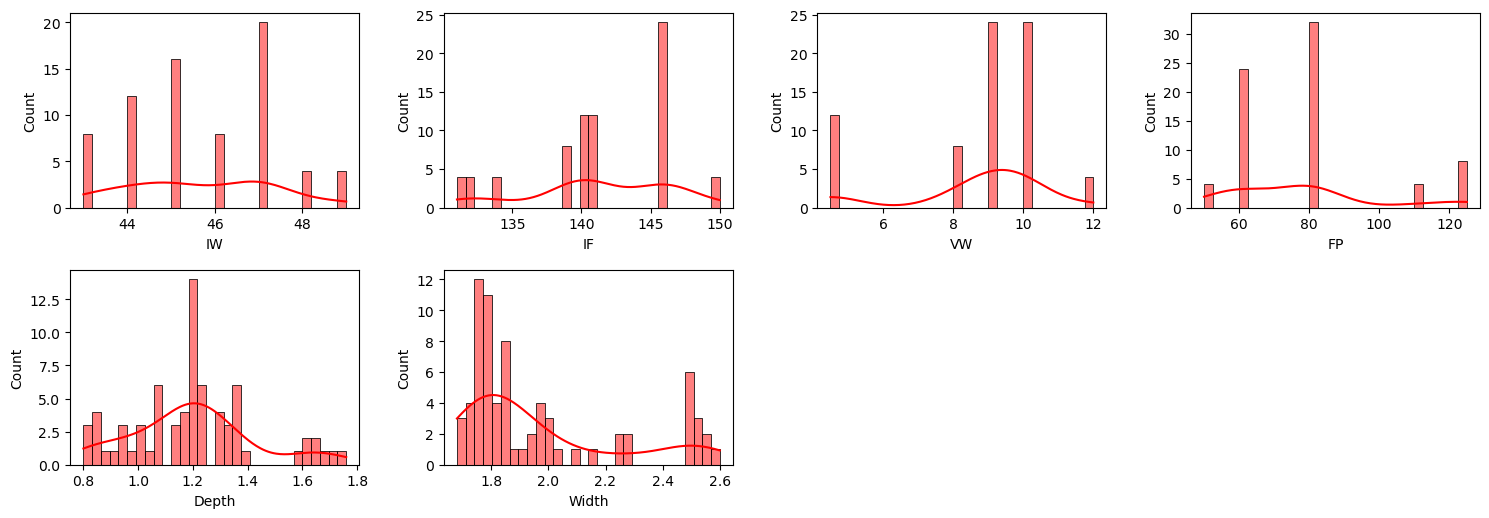

In [4]:
from matplotlib.colorbar import colorbar_factory
def histodraw(dataFrame, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(15, 10))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        sns.histplot(data=dataFrame, x=var_name, kde=True,
                    bins=30, color = 'red')
    fig.tight_layout()
    plt.show()
histodraw(pddata_x, pddata_x.columns, 4, 4)

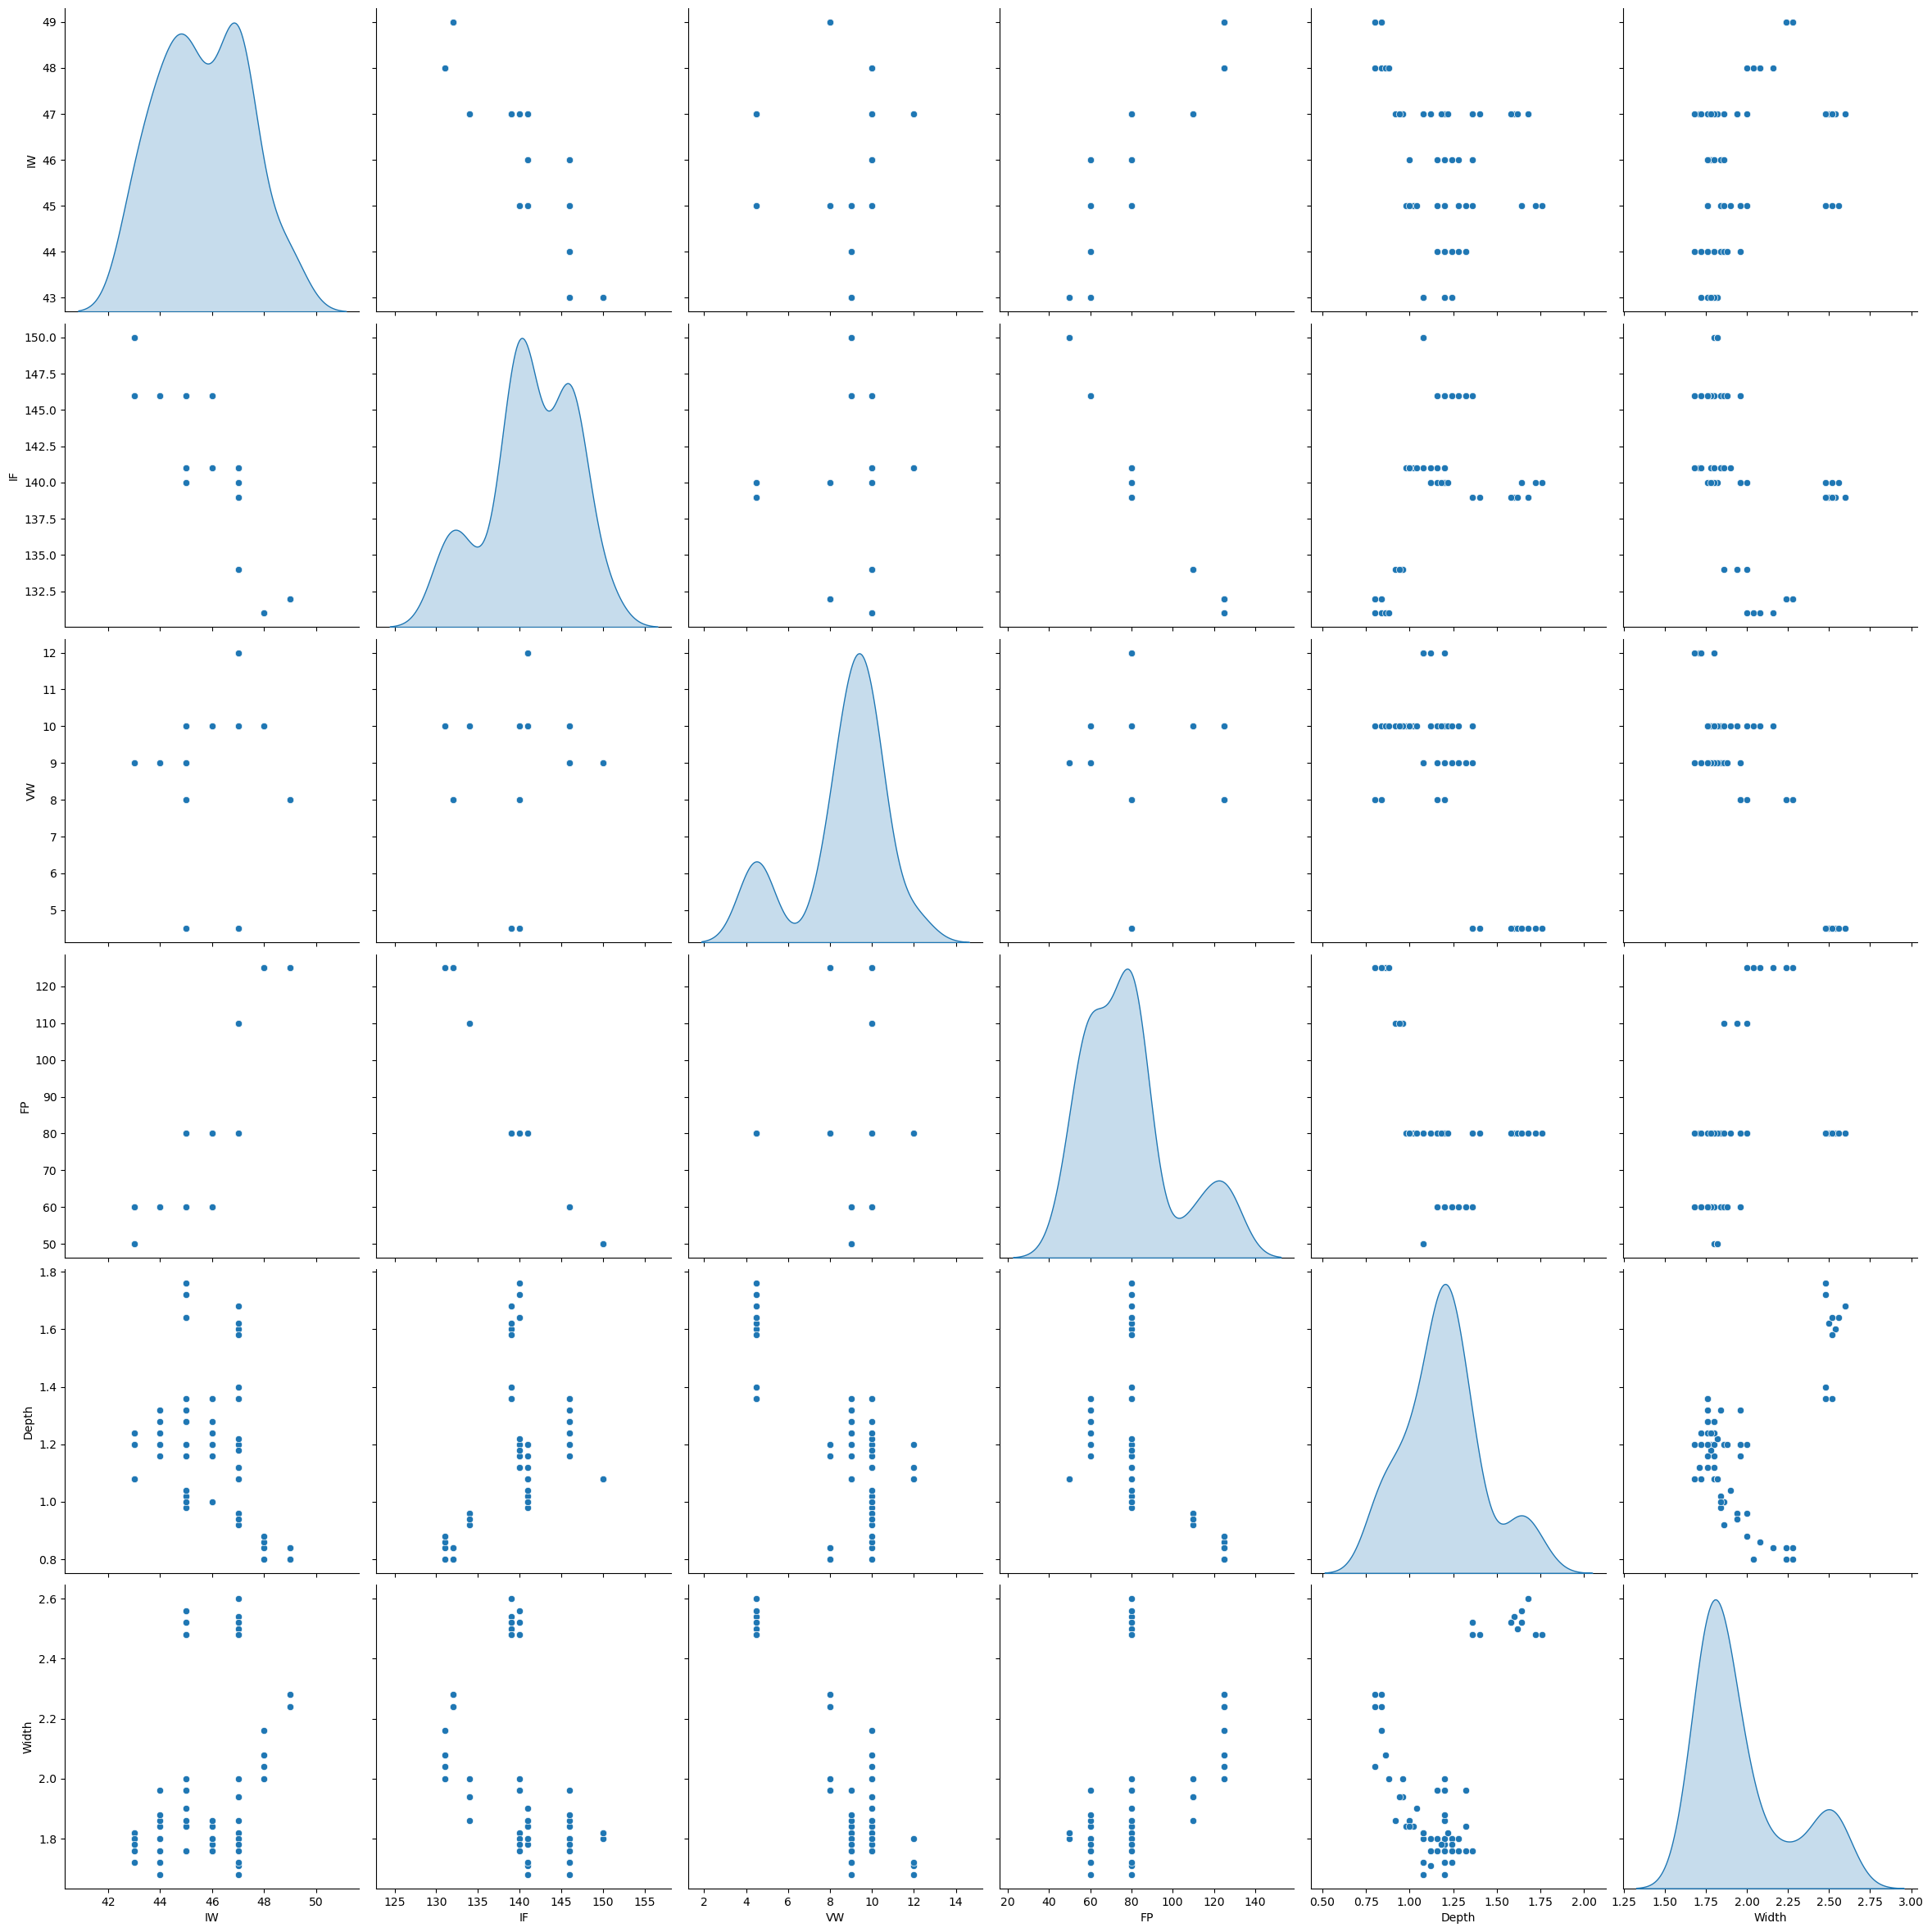

In [5]:
## зависимость 'ширина шва' и 'глубина шва' от входных параметров
g=sns.pairplot(pddata_x[['IW', 'IF', 'VW', 'FP', 'Depth', 'Width']],
               diag_kind = 'kde', height = 4)#corner=True)
#g.map_lower(sns.kdeplot, levels=4, color=".2")

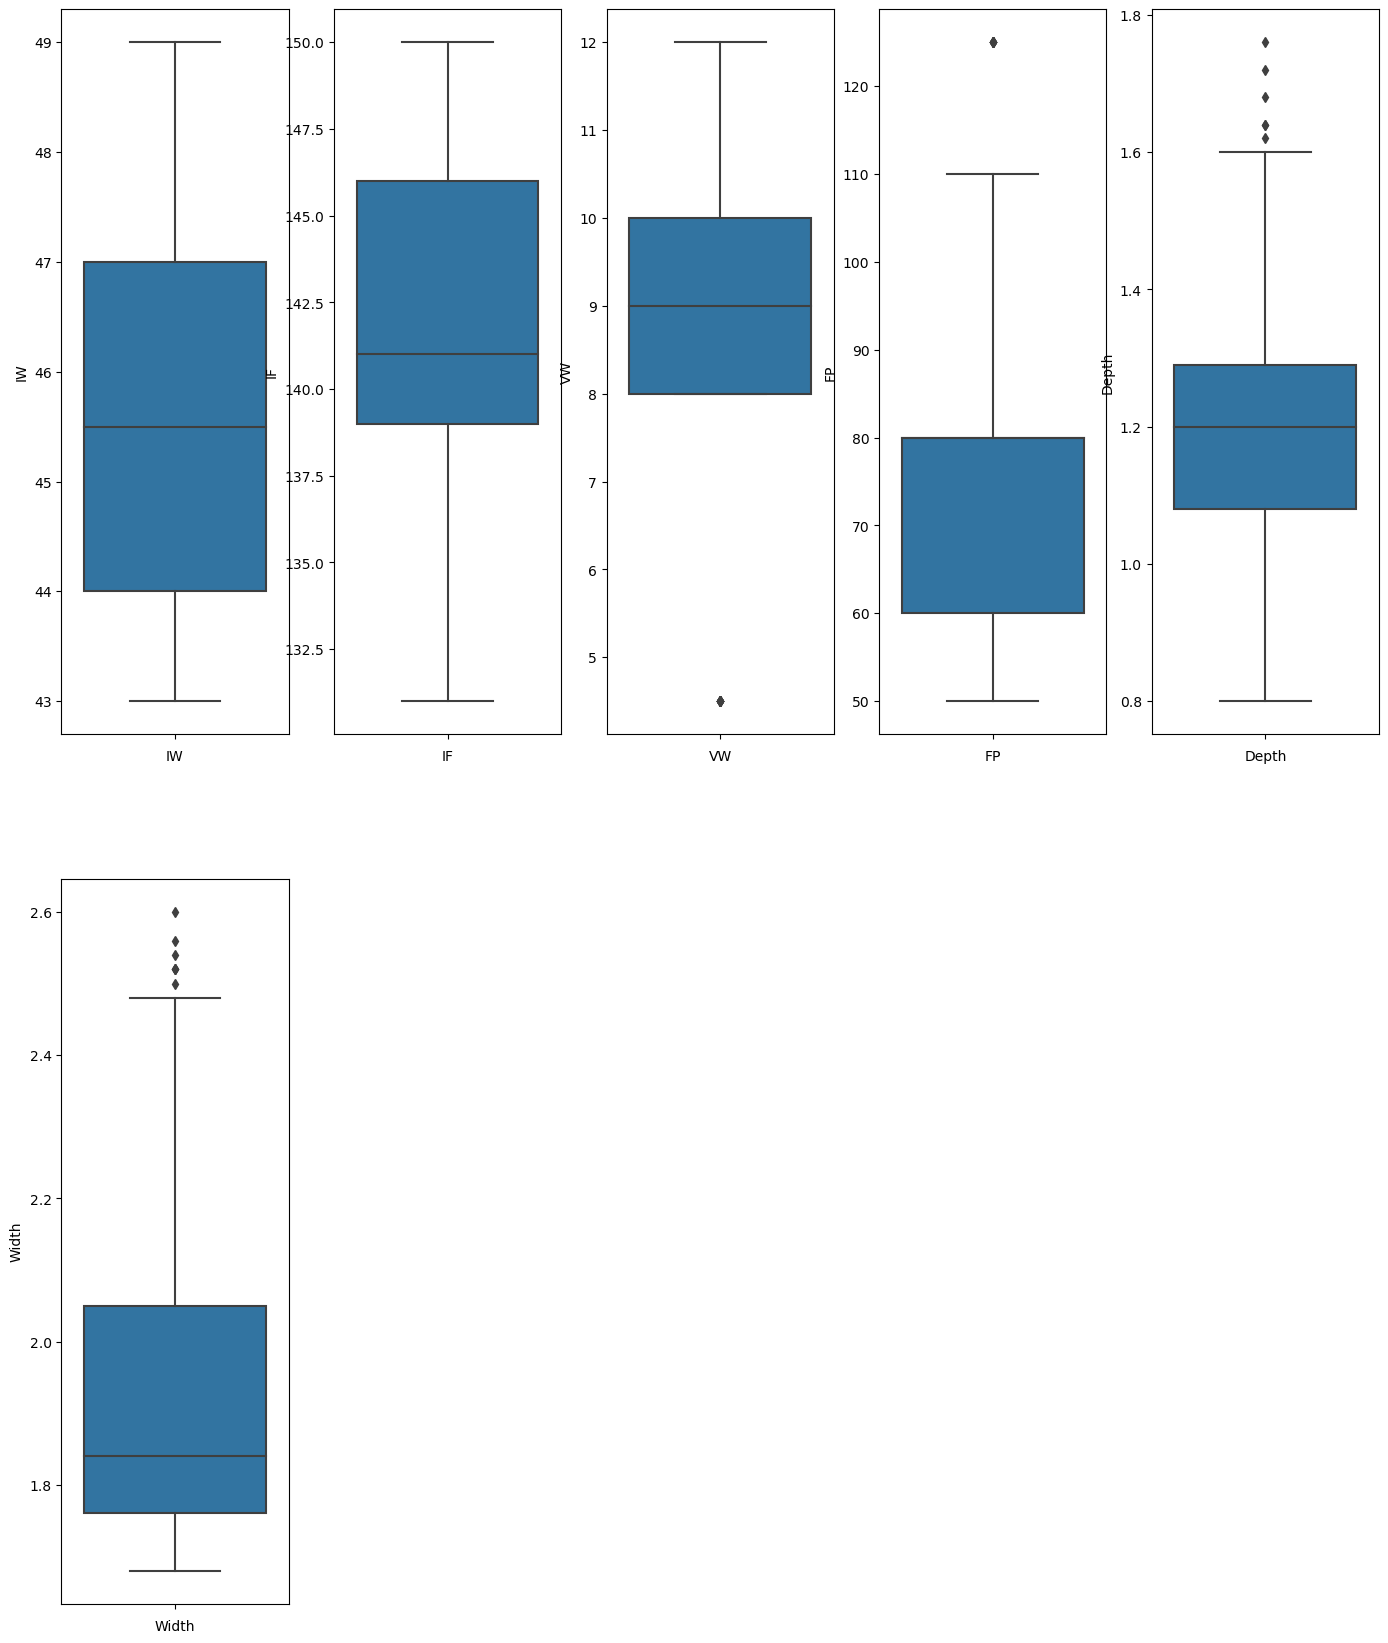

In [6]:
#Диаграмма "Ящик с усами" до удаления выбросов
n = 1 # счетчик
s = 3 # строки
c = 5 # столбцы
fig = plt.figure(figsize=(17, 32))
for i in pddata_x.columns:
    plt.subplot(s, c, n)
    plt.xlabel(i)
    sns.boxplot(y = pddata_x[i])
    n = n + 1
plt.show()

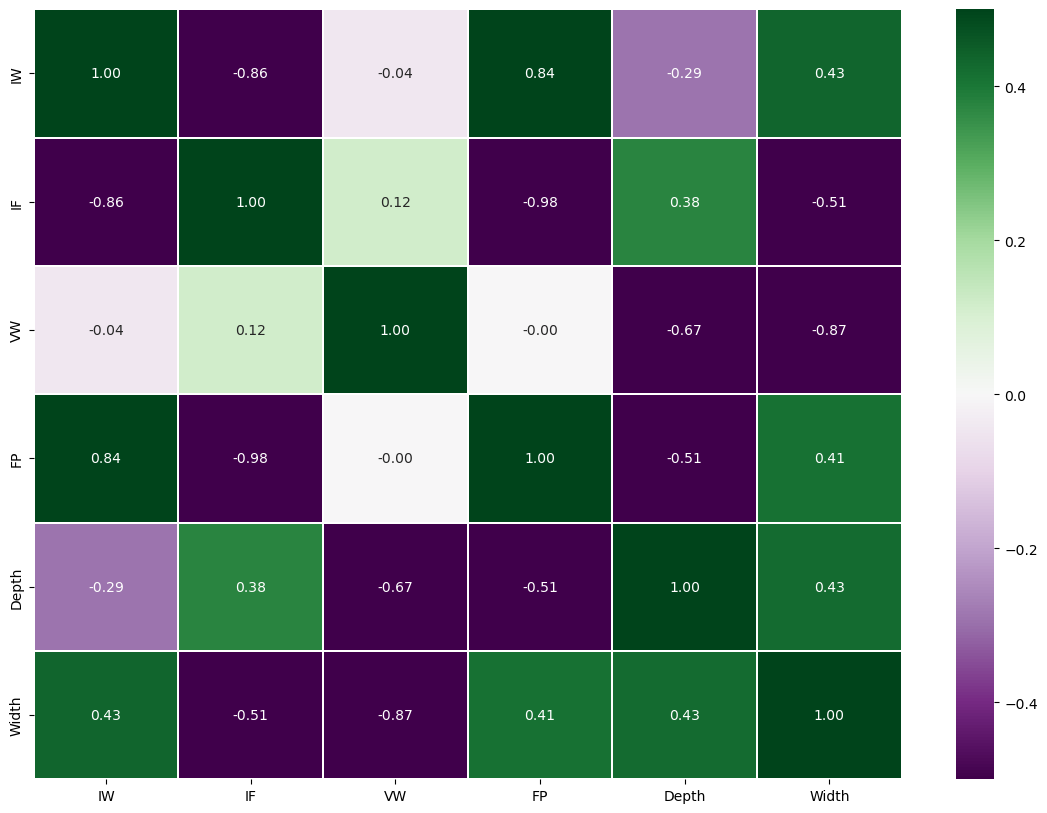

In [7]:
#Визуализация данных с помощью корреляционной матрицы до удаления выбросов
cor_map = pddata_x.corr()
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(cor_map, vmin=-0.5, vmax=0.5, annot=True,
fmt='.2f',cmap='PRGn', ax=ax, linewidths = 0.1)
plt.show()
#наблюдаем сильную отрицательную корреляцию парамеиров "IF" и "FP"

In [8]:
#Сравнение двух методов удаления выбросов: 3-х сигм или
#межквартильных расстояний
sgm = 0
iqd= 0
for column in pddata_x:
    d = pddata_x.loc[:, [column]]
    # методом 3-х сигм
    zscore = (pddata_x[column] - pddata_x[column].mean()) / pddata_x[column].std()
    d['3s'] = zscore.abs() > 3
    sgm += d['3s'].sum()
    # методом межквартильных расстояний
    q1 = np.quantile(pddata_x[column], 0.25)
    q3 = np.quantile(pddata_x[column], 0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    d['iq'] = (pddata_x[column] <= lower) | (pddata_x[column] >= upper)
    iqd+= d['iq'].sum()
print( sgm,'-- выброс методом 3-х сигм',)
print( iqd,'-- выброс методом межквартильных расстояний',)

0 -- выброс методом 3-х сигм
37 -- выброс методом межквартильных расстояний


In [9]:
#Распределение выбросов по характеристикам
temp_dataFrame = pddata_x.copy()
for i in pddata_x.columns:
    print(f"_______________________________________")
    temp_dataFrame[i] = abs((pddata_x[i] - pddata_x[i].mean()) / pddata_x[i].std())
    print(f"{sum(temp_dataFrame[i] > 3)} -> выбросов в признаке: '{i}'")
print(f' Всего - {sum(sum(temp_dataFrame.values > 3))} выброса')

_______________________________________
0 -> выбросов в признаке: 'IW'
_______________________________________
0 -> выбросов в признаке: 'IF'
_______________________________________
0 -> выбросов в признаке: 'VW'
_______________________________________
0 -> выбросов в признаке: 'FP'
_______________________________________
0 -> выбросов в признаке: 'Depth'
_______________________________________
0 -> выбросов в признаке: 'Width'
 Всего - 0 выброса


<AxesSubplot:ylabel='Density'>

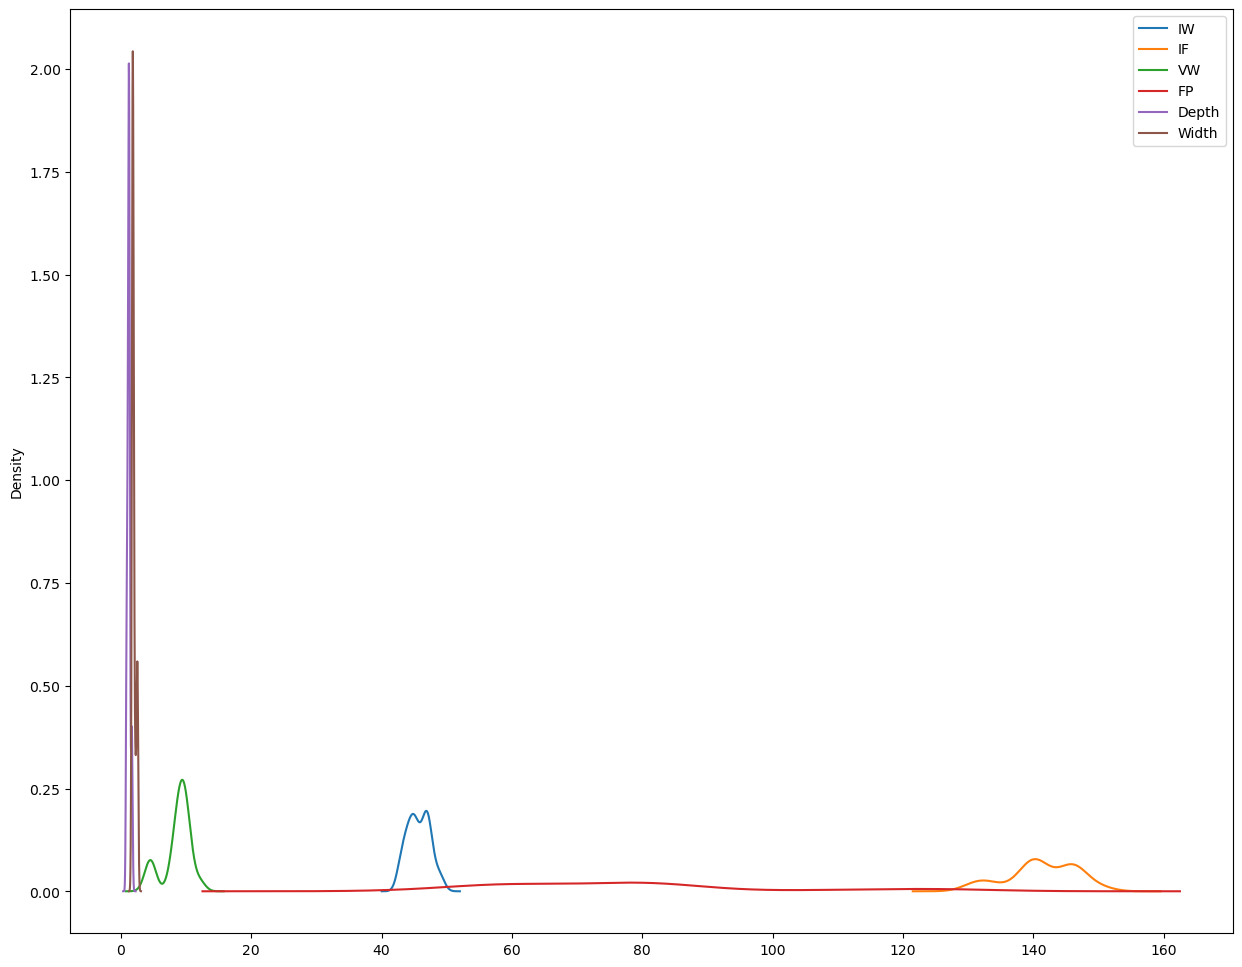

In [10]:
#Оценка плотности ядра
fig, ax = plt.subplots(figsize=(15, 12))
pddata_x.plot(kind='kde', ax=ax)

   count          mean       std       min       25%       50%       75%  \
0   72.0  1.437122e-15  1.007018 -1.600000 -1.000000 -0.100000  0.800000   
1   72.0 -1.844204e-15  1.007018 -2.022217 -0.456630 -0.065233  0.913259   
2   72.0 -6.784696e-17  1.007018 -2.022210 -0.312153  0.176434  0.665022   
3   72.0  3.361509e-16  1.007018 -1.327477 -0.858956  0.078087  0.078087   

        max  
0  2.000000  
1  1.696053  
2  1.642198  
3  2.186433  
   count      mean       std       min       25%       50%       75%       max
0   48.0 -0.025000  1.025318 -1.600000 -1.000000 -0.400000  0.800000  2.000000
1   48.0  0.032616  0.988022 -2.022217 -0.456630 -0.065233  0.913259  1.696053
2   48.0  0.049198  0.970643 -2.022210  0.054288  0.176434  0.665022  1.642198
3   48.0 -0.029283  0.979635 -1.327477 -0.858956  0.078087  0.078087  2.186433
       count      mean       std   min   25%   50%   75%   max
Depth   48.0  1.185000  0.213402  0.80  1.07  1.20  1.28  1.68
Width   48.0  1.953125  0.27

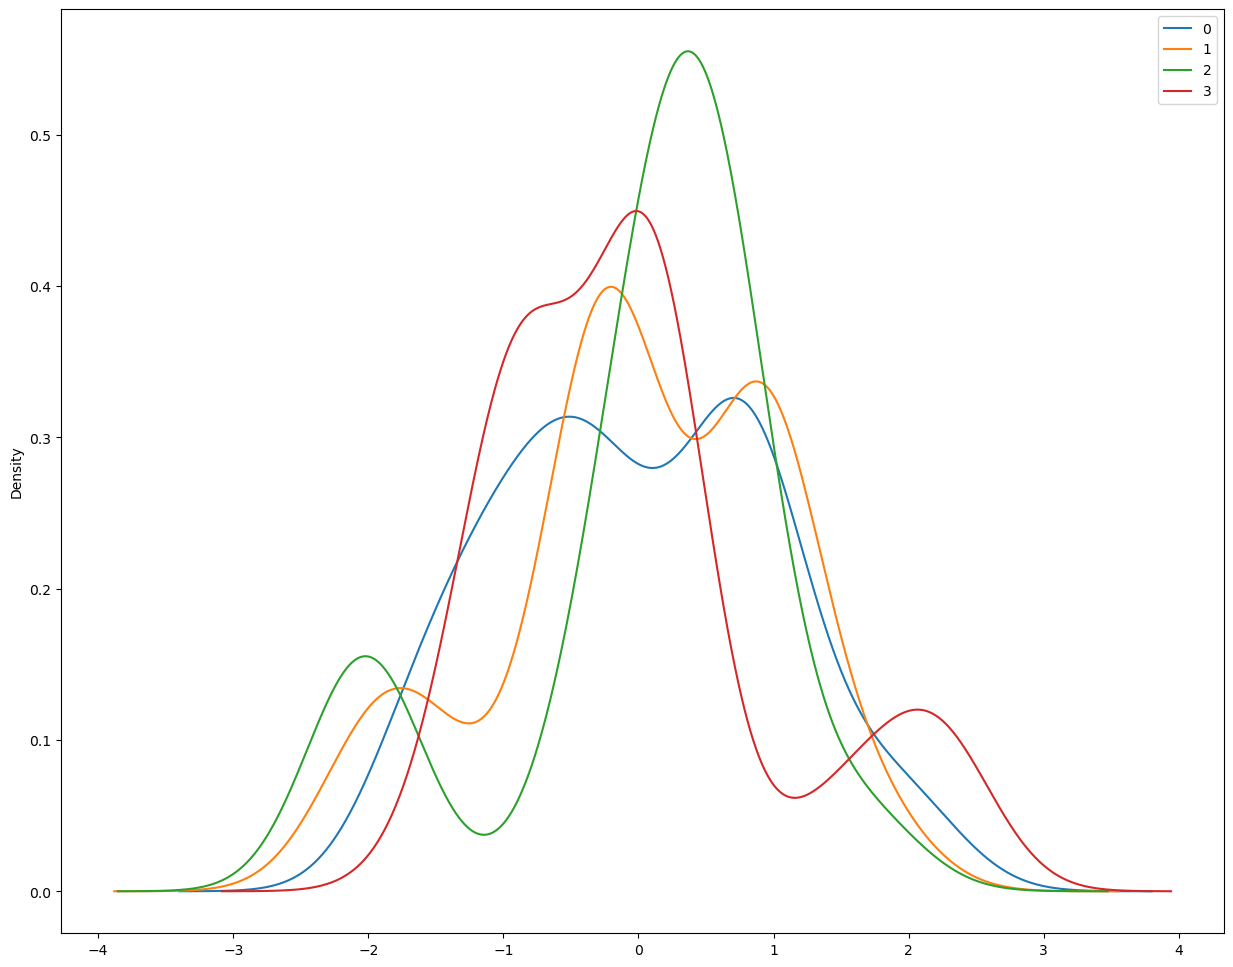

In [11]:
#разбиваем на x и у
X = pddata_x[['IW','IF', 'VW', 'FP']]
Y = pddata_x.drop(['IW','IF', 'VW', 'FP'],
                 axis=1)

#Стандартизация                                                                     #значения метрик предсказания не изменяются
scaler = StandardScaler()
scaler.fit(X)
X_st=pd.DataFrame(scaler.transform (X))
print (X_st.describe().T)

#histodraw(X_st, X_st.columns, 4, 4)
fig, ax = plt.subplots(figsize=(15, 12))
X_st.plot(kind='kde', ax=ax)

#Разбиваем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_st, Y,
                                                    train_size=0.67,  
                                                    random_state=42)
print(X_train.describe().T)
print(y_train.describe().T)


In [12]:
# Линейная регрессия
RegressionL = LinearRegression()
RegressionL.fit(X_train, y_train)
y_fit = RegressionL.predict(X_train)
RegressionL.coef_
print(sklearn.metrics.mean_absolute_error(y_fit, y_train)) #метрика на обучающей выборке
print(sklearn.metrics.mean_squared_error(y_fit, y_train))

0.06140311021629165
0.005635990364319131


In [13]:
y_fit_test_l=RegressionL.predict(X_test)
print('MAE =', sklearn.metrics.mean_absolute_error(y_fit_test_l, y_test))#метрика на тестовой выборке
print('MSE = ', sklearn.metrics.mean_squared_error(y_fit_test_l, y_test))
print ('R Squared =', sklearn.metrics.r2_score(y_fit_test_l, y_test))

MAE = 0.07198551572932504
MSE =  0.009898649259872147
R Squared = 0.8199712386413678


In [14]:
test_results = {}
test_results['RegressionL_model'] = [sklearn.metrics.mean_absolute_error(y_fit_test_l, y_test),
                                    sklearn.metrics.mean_squared_error(y_fit_test_l, y_test),
                                    sklearn.metrics.r2_score(y_fit_test_l, y_test)]

In [15]:
#полиномиальная регрессия
model_poly = Pipeline([('poly', PolynomialFeatures(degree =2)),
                      ('linear', LinearRegression(fit_intercept=False))])
model_poly.fit(X_train, y_train)
y_fit2 = model_poly.predict(X_train)
#метрики на обучающей выборке
print(sklearn.metrics.mean_absolute_error(y_fit2, y_train))#метрика на обучающей выборке
print(sklearn.metrics.mean_squared_error(y_fit2, y_train))

0.03126388888888924
0.002300173611111111


In [16]:
y_fit_test=model_poly.predict(X_test)
print('MAE = ', sklearn.metrics.mean_absolute_error(y_fit_test, y_test))#метрика на тестовой выборке
print('MSE = ', sklearn.metrics.mean_squared_error(y_fit_test, y_test))
print ('R Squared =',sklearn.metrics.r2_score(y_fit_test, y_test))

MAE =  0.05393055555555573
MSE =  0.005047002314814831
R Squared = 0.9229904647552887


In [17]:
test_results['polynom_model'] = [sklearn.metrics.mean_absolute_error(y_fit_test, y_test),
                                    sklearn.metrics.mean_squared_error(y_fit_test, y_test),
                                    sklearn.metrics.r2_score(y_fit_test, y_test)]

In [18]:
### случайный лес
ForestReg = RandomForestRegressor(n_estimators=100, min_samples_leaf = 1, min_samples_split = 2, max_depth = 10,                             
                                  random_state=10, criterion = 'squared_error')
ForestReg.fit(X_train, y_train)
y_fit3 = ForestReg.predict(X_train)
#метрики на обучающей выборке
print(sklearn.metrics.mean_absolute_error(y_fit3, y_train))
print(sklearn.metrics.mean_squared_error(y_fit3, y_train))
print(sklearn.metrics.r2_score(y_fit3, y_train))

0.034328321785274854
0.0024791398409219454
0.9484735276489973


In [19]:
y_fit_test3=ForestReg.predict(X_test)
print('MAE = ', sklearn.metrics.mean_absolute_error(y_fit_test3, y_test))#метрики на тестовой выборке
print('MSE = ', sklearn.metrics.mean_squared_error(y_fit_test3, y_test))
print ('R Squared =',sklearn.metrics.r2_score(y_fit_test3, y_test))

MAE =  0.05128412315115459
MSE =  0.004571381835928834
R Squared = 0.9197056533431672


In [20]:
test_results['RandomForest_model'] = [sklearn.metrics.mean_absolute_error(y_fit_test3, y_test),
                                    sklearn.metrics.mean_squared_error(y_fit_test3, y_test),
                                    sklearn.metrics.r2_score(y_fit_test3, y_test)]

In [21]:
## пробуем линейную регреессию на основе нейросети
linear_model = tf.keras.Sequential([
    #normalizer,
    layers.Dense(2, input_dim = 4, 
                 activation = 'relu'),
])
linear_model.layers[0].kernel

<tf.Variable 'dense/kernel:0' shape=(4, 2) dtype=float32, numpy=
array([[-0.2129538 , -0.27346516],
       [ 0.79515195, -0.49075222],
       [ 0.8420017 ,  0.8355775 ],
       [-0.9640763 , -0.6590495 ]], dtype=float32)>

In [22]:
linear_model.compile(
     optimizer = tf.optimizers.Adam(learning_rate = 0.1),
     loss = 'mean_absolute_error')
linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [23]:
#обучаем модель
#%%time
history = linear_model.fit(
    np.array(X_train),
    np.array(y_train),
    epochs = 50,
    verbose = 1,
    validation_split = 0.2
)

Epoch 1/50
2/2 [==============================] - 2s 243ms/step - loss: 1.2770 - val_loss: 0.6919
Epoch 2/50
2/2 [==============================] - 0s 86ms/step - loss: 0.9760 - val_loss: 0.7885
Epoch 3/50
2/2 [==============================] - 0s 67ms/step - loss: 0.9479 - val_loss: 0.9625
Epoch 4/50
2/2 [==============================] - 0s 67ms/step - loss: 0.9447 - val_loss: 1.0520
Epoch 5/50
2/2 [==============================] - 0s 67ms/step - loss: 0.8779 - val_loss: 1.0924
Epoch 6/50
2/2 [==============================] - 0s 69ms/step - loss: 0.8064 - val_loss: 1.1054
Epoch 7/50
2/2 [==============================] - 0s 67ms/step - loss: 0.7087 - val_loss: 1.1663
Epoch 8/50
2/2 [==============================] - 0s 69ms/step - loss: 0.6778 - val_loss: 1.2745
Epoch 9/50
2/2 [==============================] - 0s 66ms/step - loss: 0.7007 - val_loss: 1.3163
Epoch 10/50
2/2 [==============================] - 0s 67ms/step - loss: 0.7147 - val_loss: 1.2827
Epoch 11/50
2/2 [===========

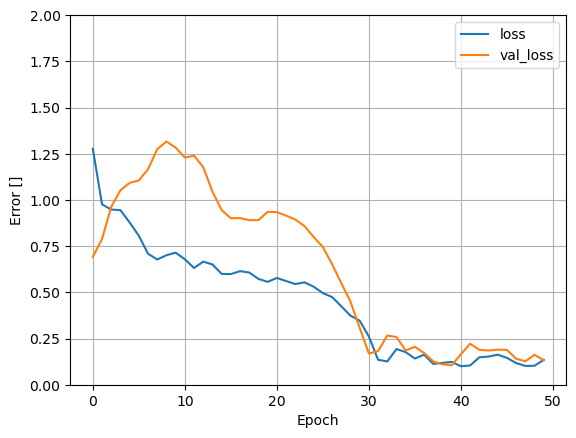

In [24]:
plot_loss(history)

In [25]:
y_fit_test4=linear_model.predict(X_test)
test_results['linear_model'] = [sklearn.metrics.mean_absolute_error(y_fit_test4, y_test),
                                    sklearn.metrics.mean_squared_error(y_fit_test4, y_test),
                                    sklearn.metrics.r2_score(y_fit_test4, y_test)]

1/1 [==============================] - 0s 159ms/step


In [26]:
y_fit_test4=linear_model.predict(X_test)
print('MAE = ', sklearn.metrics.mean_absolute_error(y_fit_test4, y_test))#метрика на тестовой выборке
print('MSE = ', sklearn.metrics.mean_squared_error(y_fit_test4, y_test))
print ('R Squared =',sklearn.metrics.r2_score(y_fit_test4, y_test))

1/1 [==============================] - 0s 61ms/step
MAE =  0.126647413422664
MSE =  0.02531112166390155
R Squared = 0.5386710437086099


In [27]:
##Построение многослойного персептрона на основе полносвязных слоев
def build_and_compile_model():
  model = keras.Sequential([
      layers.Dense(64,  input_dim = 4, activation = 'relu'),
      layers.Dense(128, activation = 'relu'),
      layers.Dropout(0.2),
      layers.Dense(64, activation = 'relu'),
      layers.Dense(2)
  ])
  model.compile(loss = 'mean_absolute_error',
                optimizer = keras.optimizers.Adam(0.001))
  return model

In [28]:
dnn_model = build_and_compile_model()
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                320       
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 17,026
Trainable params: 17,026
Non-trainable params: 0
_________________________________________________________________


In [30]:
#обучаем модель
#%%time
history = dnn_model.fit(
    X_train,
    y_train,
    epochs = 200, verbose = 1,
    validation_split = 0.2)

Epoch 1/200
2/2 [==============================] - 1s 260ms/step - loss: 1.5318 - val_loss: 1.4120
Epoch 2/200
2/2 [==============================] - 0s 71ms/step - loss: 1.3834 - val_loss: 1.2604
Epoch 3/200
2/2 [==============================] - 0s 74ms/step - loss: 1.2415 - val_loss: 1.1117
Epoch 4/200
2/2 [==============================] - 0s 73ms/step - loss: 1.0942 - val_loss: 0.9589
Epoch 5/200
2/2 [==============================] - 0s 70ms/step - loss: 0.9690 - val_loss: 0.7932
Epoch 6/200
2/2 [==============================] - 0s 67ms/step - loss: 0.8045 - val_loss: 0.6389
Epoch 7/200
2/2 [==============================] - 0s 73ms/step - loss: 0.6232 - val_loss: 0.5173
Epoch 8/200
2/2 [==============================] - 0s 72ms/step - loss: 0.5972 - val_loss: 0.4918
Epoch 9/200
2/2 [==============================] - 0s 71ms/step - loss: 0.5271 - val_loss: 0.4589
Epoch 10/200
2/2 [==============================] - 0s 70ms/step - loss: 0.5063 - val_loss: 0.4359
Epoch 11/200
2/2 [

Epoch 84/200
2/2 [==============================] - 0s 72ms/step - loss: 0.1296 - val_loss: 0.3886
Epoch 85/200
2/2 [==============================] - 0s 67ms/step - loss: 0.1270 - val_loss: 0.4019
Epoch 86/200
2/2 [==============================] - 0s 69ms/step - loss: 0.1371 - val_loss: 0.4130
Epoch 87/200
2/2 [==============================] - 0s 68ms/step - loss: 0.1642 - val_loss: 0.4158
Epoch 88/200
2/2 [==============================] - 0s 67ms/step - loss: 0.1427 - val_loss: 0.4051
Epoch 89/200
2/2 [==============================] - 0s 64ms/step - loss: 0.1077 - val_loss: 0.3926
Epoch 90/200
2/2 [==============================] - 0s 67ms/step - loss: 0.1279 - val_loss: 0.3801
Epoch 91/200
2/2 [==============================] - 0s 67ms/step - loss: 0.1046 - val_loss: 0.3752
Epoch 92/200
2/2 [==============================] - 0s 64ms/step - loss: 0.1049 - val_loss: 0.3767
Epoch 93/200
2/2 [==============================] - 0s 65ms/step - loss: 0.1332 - val_loss: 0.3828
Epoch 94/2

2/2 [==============================] - 0s 66ms/step - loss: 0.1182 - val_loss: 0.3738
Epoch 167/200
2/2 [==============================] - 0s 65ms/step - loss: 0.1318 - val_loss: 0.3380
Epoch 168/200
2/2 [==============================] - 0s 66ms/step - loss: 0.1172 - val_loss: 0.3141
Epoch 169/200
2/2 [==============================] - 0s 64ms/step - loss: 0.0891 - val_loss: 0.3359
Epoch 170/200
2/2 [==============================] - 0s 67ms/step - loss: 0.1203 - val_loss: 0.3491
Epoch 171/200
2/2 [==============================] - 0s 68ms/step - loss: 0.1154 - val_loss: 0.3477
Epoch 172/200
2/2 [==============================] - 0s 66ms/step - loss: 0.0867 - val_loss: 0.3600
Epoch 173/200
2/2 [==============================] - 0s 63ms/step - loss: 0.1112 - val_loss: 0.3764
Epoch 174/200
2/2 [==============================] - 0s 67ms/step - loss: 0.1095 - val_loss: 0.3648
Epoch 175/200
2/2 [==============================] - 0s 118ms/step - loss: 0.1069 - val_loss: 0.3437
Epoch 176/200

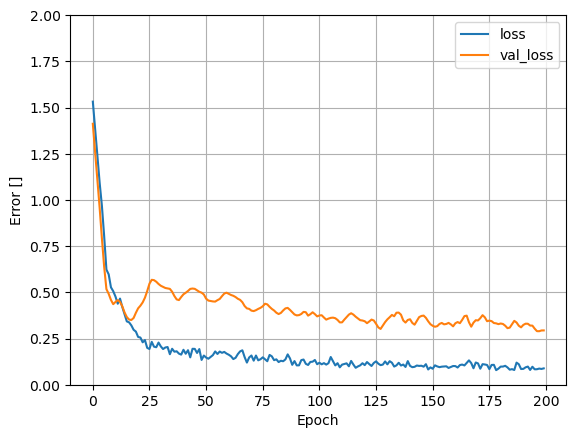

In [31]:
plot_loss(history)

In [32]:
y_fit_test5=dnn_model.predict(X_test)
test_results['dnn_model'] = [sklearn.metrics.mean_absolute_error(y_fit_test5, y_test),
                                    sklearn.metrics.mean_squared_error(y_fit_test5, y_test),
                                    sklearn.metrics.r2_score(y_fit_test5, y_test)]

1/1 [==============================] - 0s 127ms/step


In [33]:
print('MAE = ', sklearn.metrics.mean_absolute_error(y_fit_test5, y_test))#метрика на тестовой выборке
print('MSE = ', sklearn.metrics.mean_squared_error(y_fit_test5, y_test))
print ('R Squared =',sklearn.metrics.r2_score(y_fit_test5, y_test))

MAE =  0.09791065538922947
MSE =  0.03007664196580928
R Squared = 0.7194514674309725


In [34]:
pd.DataFrame(test_results).T#оцениваем качество моделей по трем метрикам на тестовой выборке

,0,1,2
RegressionL_model,0.071986,0.009899,0.819971
polynom_model,0.053931,0.005047,0.922990
RandomForest_model,0.051284,0.004571,0.919706
linear_model,0.126647,0.025311,0.538671
dnn_model,0.097911,0.030077,0.719451


In [35]:
##По совокупности  метрик выбираем модель леса 
##Сохранение модели

## Сохранение
pkl_filename = name_dir + 'RandomForestRegressor_model.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(ForestReg, file)
    
pkl_filename_scaler = name_dir + 'Scaler_model.pkl'
with open(pkl_filename_scaler, 'wb') as file:
     pickle.dump(scaler, file)

   
 
# Загрузка
with open(pkl_filename, 'rb') as file: 
    pickle_model = pickle.load(file) 
with open(pkl_filename_scaler, 'rb') as file: 
    pickle_scaler = pickle.load(file) 


###еще один вариант сохранения
#from sklearn.externals import joblib 
 
# Save to file in the current working directory 
joblib_file = name_dir + "joblib_model.pkl" 
joblib_file_scaler = name_dir + "joblib_scaler.pkl" 
joblib.dump(ForestReg, joblib_file) 
joblib.dump(scaler, joblib_file_scaler)
 
 # Load from file 
joblib_model = joblib.load(joblib_file) 

In [36]:
# проверка сохраненной модели
y_fit_test_Z=pickle_model.predict(X_test)
print(sklearn.metrics.mean_absolute_error(y_fit_test_Z, y_test))#метрика на тестовой выборке
print(sklearn.metrics.mean_squared_error(y_fit_test_Z, y_test))
print ('R Squared =',sklearn.metrics.r2_score(y_fit_test_Z, y_test))

y_fit_test_Z_j=joblib_model.predict(X_test)
print(sklearn.metrics.mean_absolute_error(y_fit_test_Z_j, y_test))#метрика на тестовой выборке
print(sklearn.metrics.mean_squared_error(y_fit_test_Z_j, y_test))
print ('R Squared =',sklearn.metrics.r2_score(y_fit_test_Z_j, y_test))

0.05128412315115459
0.004571381835928834
R Squared = 0.9197056533431672
0.05128412315115459
0.004571381835928834
R Squared = 0.9197056533431672


   count          mean       std       min       25%       50%       75%  \
0   72.0  1.437122e-15  1.007018 -1.600000 -1.000000 -0.100000  0.800000   
1   72.0 -1.844204e-15  1.007018 -2.022217 -0.456630 -0.065233  0.913259   
2   72.0 -6.784696e-17  1.007018 -2.022210 -0.312153  0.176434  0.665022   
3   72.0  3.361509e-16  1.007018 -1.327477 -0.858956  0.078087  0.078087   

        max  
0  2.000000  
1  1.696053  
2  1.642198  
3  2.186433  


<AxesSubplot:ylabel='Density'>

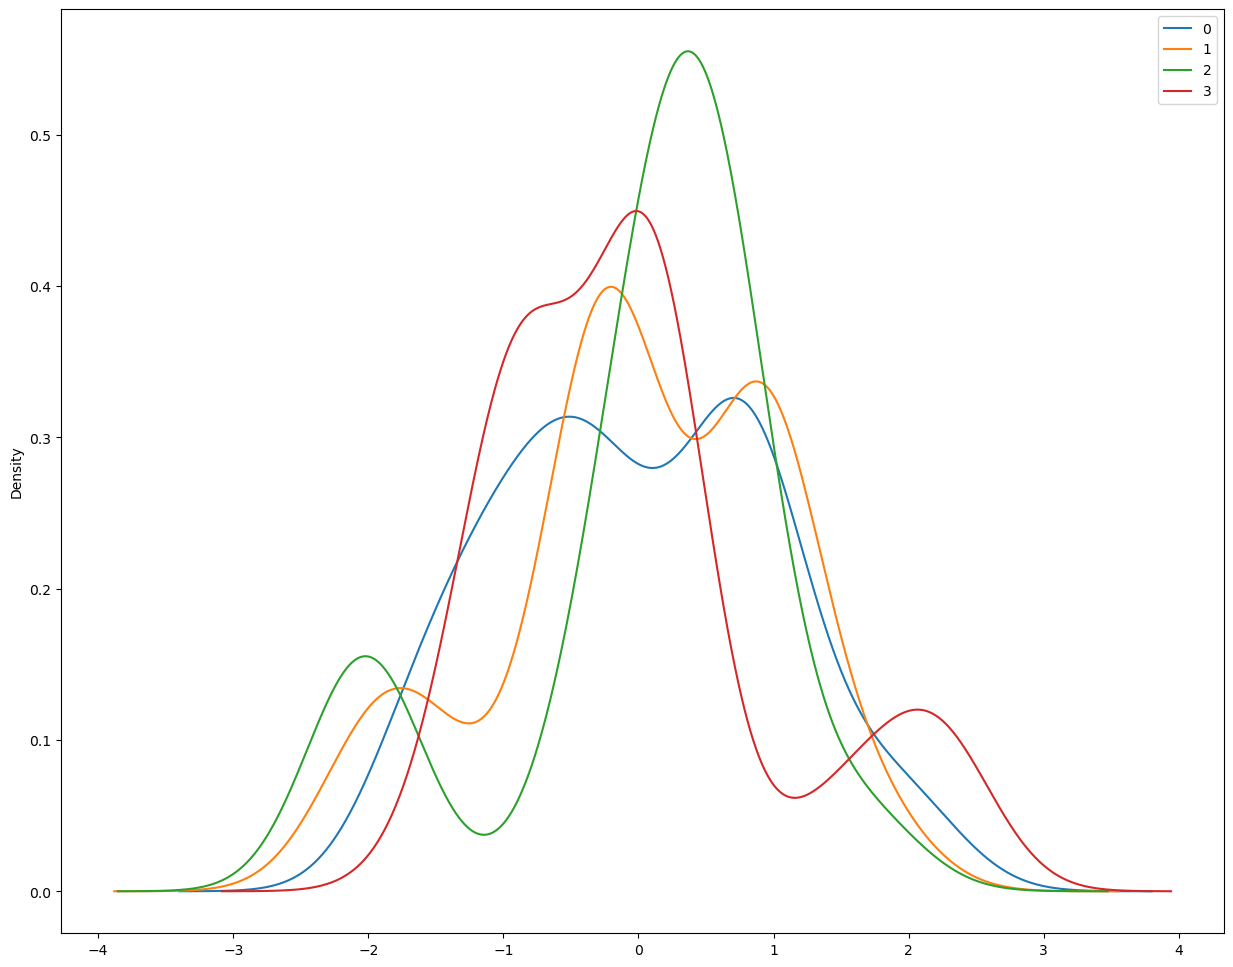

In [37]:
#проверим сохраненный скалер визуально
X_st_z=pd.DataFrame(pickle_scaler.transform (X))
print (X_st_z.describe().T)

#histodraw(X_st, X_st.columns, 4, 4)
fig, ax = plt.subplots(figsize=(15, 12))
X_st_z.plot(kind='kde', ax=ax)

In [ ]:
!pip freeze > requirements.txt #выгружаем файл зависимостей от библиотек